In [ ]:
!pip install qiskit pylatexenc matplotlib
!pip install qiskit_aer
!pip install qiskit_ibm_runtime

# Problem 0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
N_steps = 10000    # number of steps in the walk
N_trials = 5000   # number of independent trials

In [ ]:
# simulate random steps by +1 for right and -1 for left
steps = np.random.choice([-1, 1], size=(N_trials, N_steps))

In [ ]:
# compute position after each step
displacement = np.cumsum(steps, axis=1)

In [ ]:
# RMS displacement = sqrt(average(Xn^2) over trials)
rms_displacement = np.sqrt(np.mean(displacement**2, axis=0))

In [ ]:
#Theoretical RMS = sqrt(N)
n = np.arange(1, N_steps + 1)
rms_theory = np.sqrt(n)

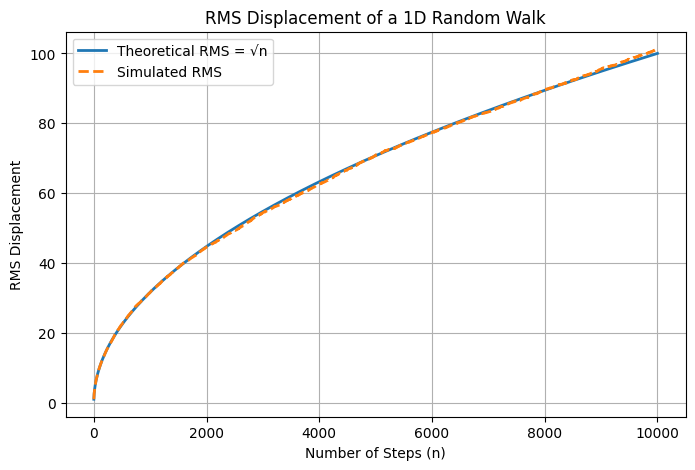

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(n, rms_theory, label="Theoretical RMS = √n", linewidth=2)
plt.plot(n, rms_displacement, '--', label="Simulated RMS", linewidth=2)
plt.xlabel("Number of Steps (n)")
plt.ylabel("RMS Displacement")
plt.title("RMS Displacement of a 1D Random Walk")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def classical_walk(t_max):
    # state: position -> probability
    state = {0: 1.0}   # Start at x=0 with probability 1
    state_history = [state]

    for t in range(t_max):
        new_state = {}
        for x, p in state.items():
            left_pos = x - 1
            right_pos = x + 1

            # Each step splits probability in half
            new_state[left_pos] = new_state.get(left_pos, 0) + p/2
            new_state[right_pos] = new_state.get(right_pos, 0) + p/2

        state = new_state
        state_history.append(state)

    return state_history

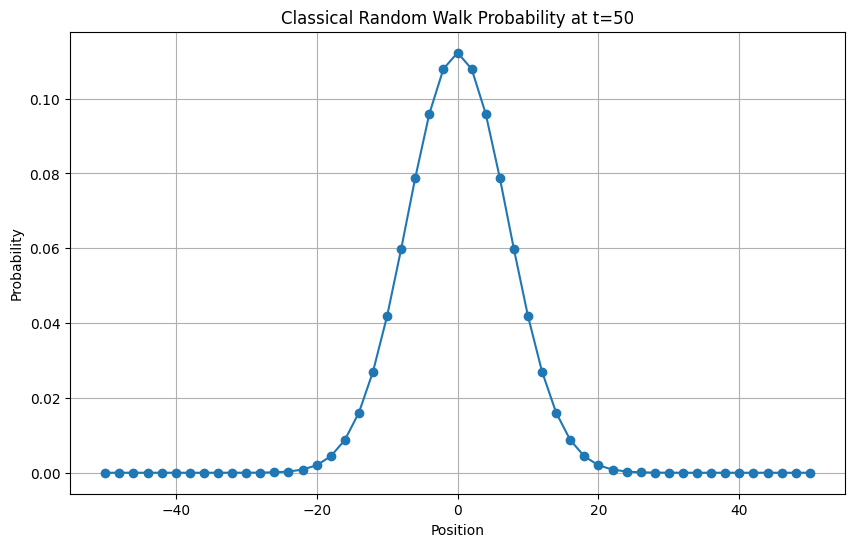

In [ ]:
t = 50
classical_states = classical_walk(t)
state_t = classical_states[-1]

positions = np.array(sorted(state_t.keys()))
probs = np.array([state_t[x] for x in positions])

plt.figure(figsize=(10,6))
plt.plot(positions, probs, marker='o')
plt.title(f"Classical Random Walk Probability at t={t}")
plt.xlabel("Position")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

# Problem 1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def quantum_walk_pauli_x(steps):
    # position of Bob
    position = 0
    # coin state: 0 means |0>, 1 means |1>
    coin = 0

    positions = [position]  # store positions step-by-step

    for _ in range(steps):
        # 1. Apply X gate → flip coin
        coin = 1 - coin

        # 2. Shift depending on coin value
        if coin == 0:
            position -= 1   # move left
        else:
            position += 1   # move right

        positions.append(position)

    return positions

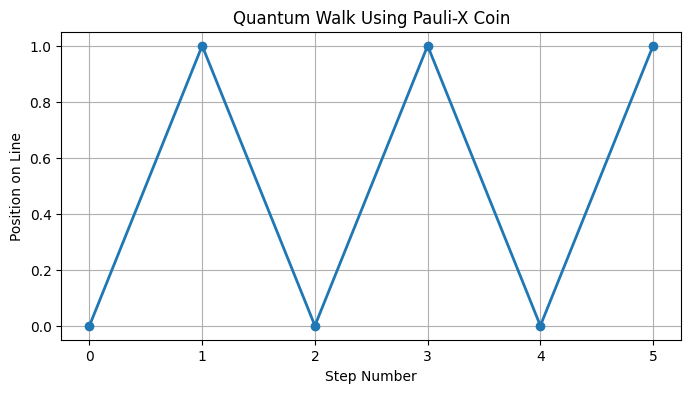

In [ ]:
steps = 5
positions = quantum_walk_pauli_x(steps)

# ---- Plot ----
plt.figure(figsize=(8, 4))
plt.plot(range(steps + 1), positions, marker='o', linewidth=2)
plt.title("Quantum Walk Using Pauli-X Coin")
plt.xlabel("Step Number")
plt.ylabel("Position on Line")
plt.grid(True)
plt.show()

## On Quantum Computer

---



In [ ]:
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile

In [ ]:
def controlled_increment(qc, control, regs):
    # toggle bit0
    qc.cx(control, regs[0])
    # propagate carries
    qc.ccx(control, regs[0], regs[1])
    qc.ccx(control, regs[0], regs[1])
    qc.ccx(control, regs[1], regs[2])
    qc.ccx(control, regs[2], regs[3])

In [ ]:
def controlled_decrement(qc, control, regs):
  # Initial borrow_in = control
  borrow = control

  # Flip the least significant bit (subtract 1)
  qc.cx(borrow, regs[0])

  # Now propagate borrow through remaining bits
  for i in range(len(regs)-1):
    # Borrow happens if original bit was 0.
    # To test "was bit_i == 0", we temporarily flip it.
    qc.ccx(borrow, regs[i], regs[i+1])       # propagate borrow

In [ ]:
qc = QuantumCircuit(5, 4)

In [ ]:
coin = 0
pos = [1,2,3,4]  # LSB first

In [ ]:
qc.x(pos[2])
for _ in range(4):

    # 1. Coin operator (Pauli-X)
    qc.x(coin)

    # 2. Controlled shift
    # If coin=1 → increment
    controlled_increment(qc, coin, pos)

    # If coin=0 → decrement
    qc.x(coin)
    controlled_decrement(qc, coin, pos)
    qc.x(coin)

In [ ]:
qc.barrier()
qc.measure(pos, range(4))

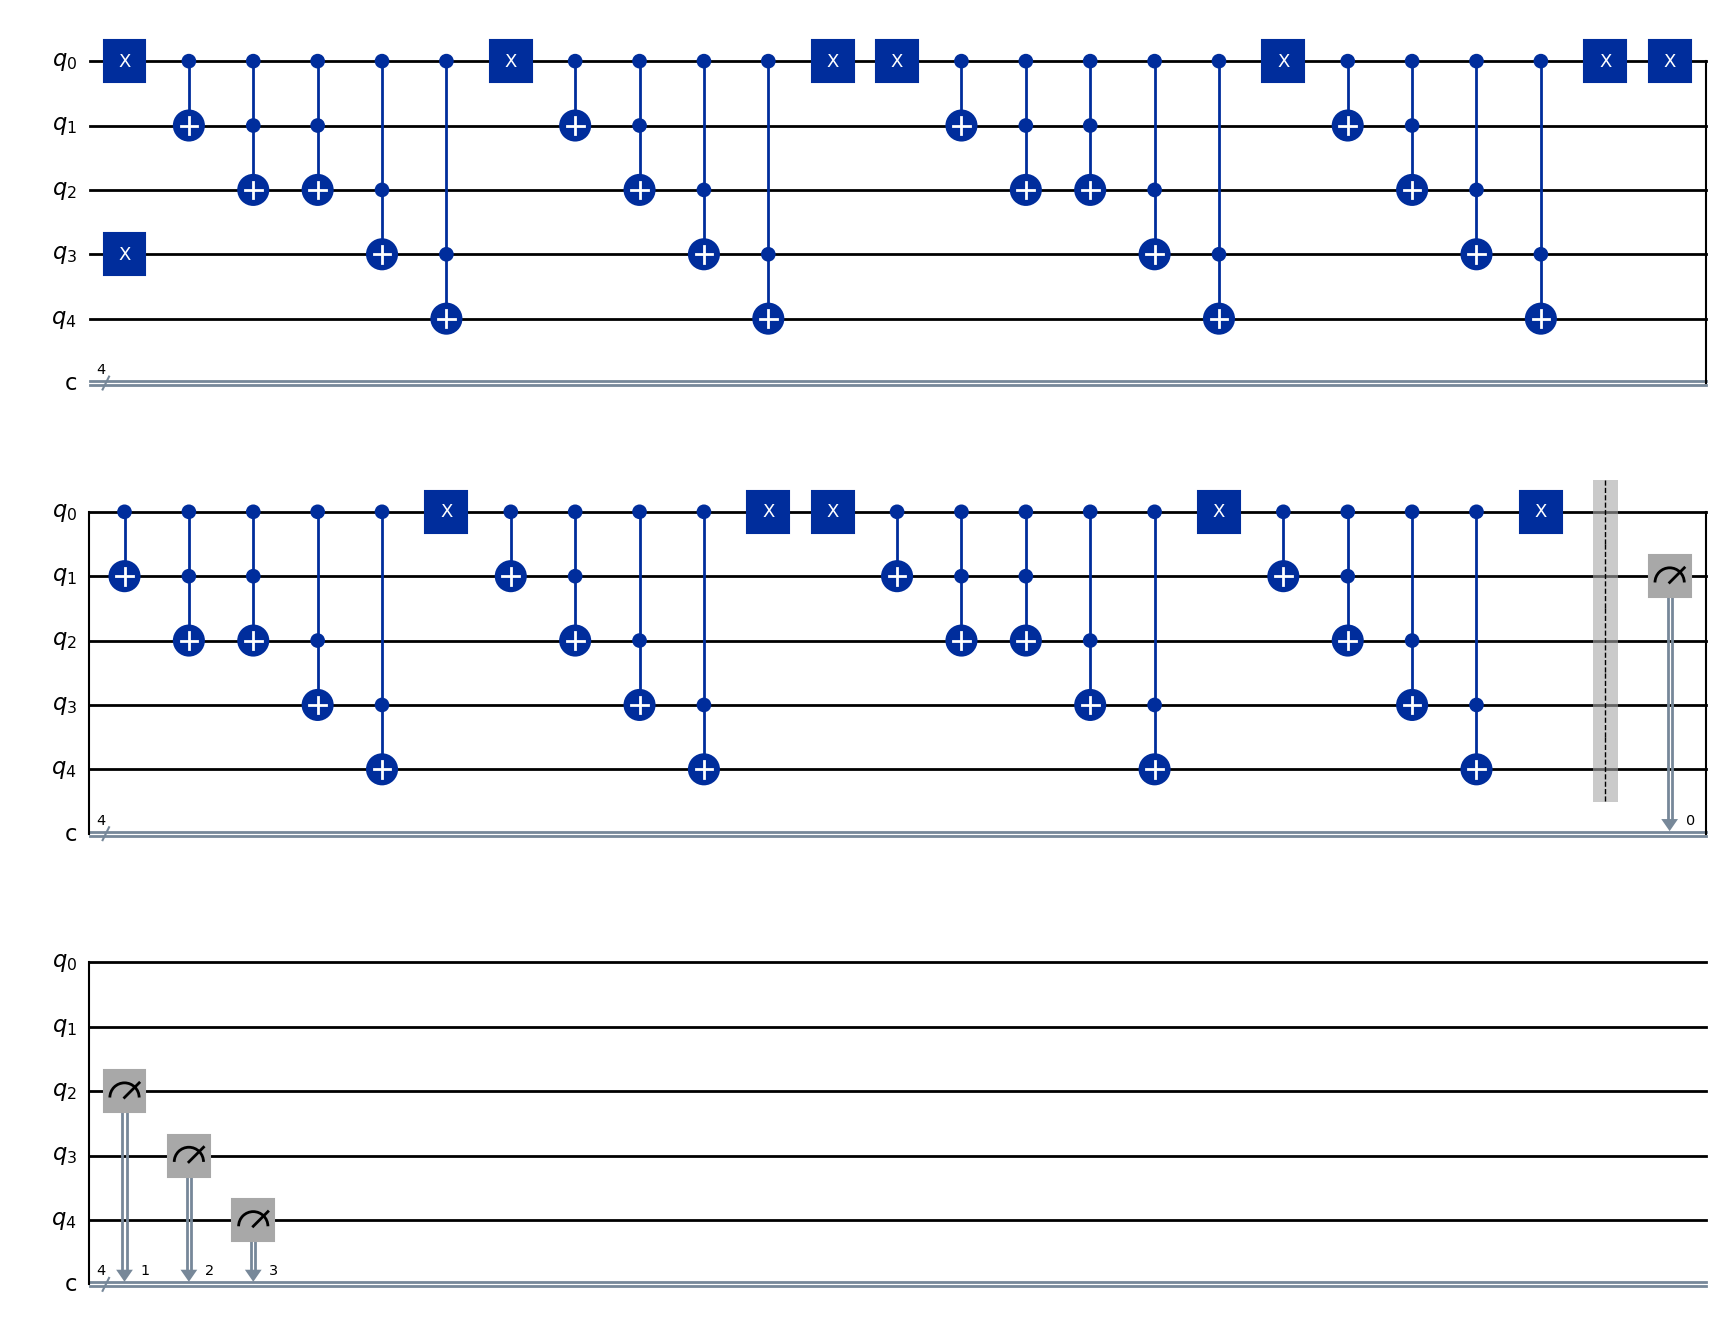

In [ ]:
qc.draw("mpl")

In [ ]:
backend = Aer.get_backend("qasm_simulator")
job = backend.run(qc, shots=1000)
counts = job.result().get_counts()

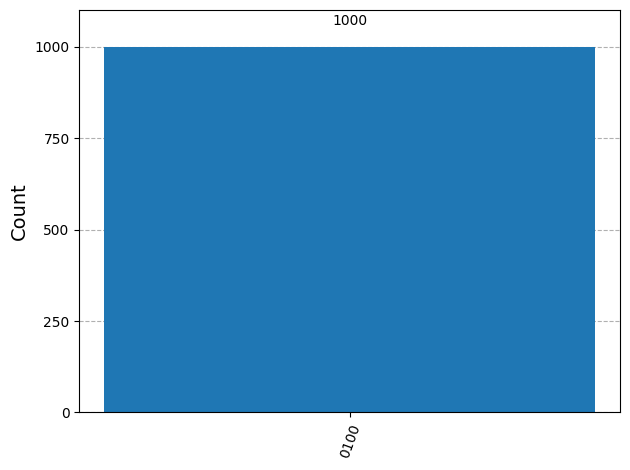

In [ ]:
plot_histogram(counts)

# Problem 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Hadamard gate
H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

def quantum_walk_all(t_max):
    # state_history[t] = state at time t
    state = {0: np.array([1, 0], dtype=complex)}
    state_history = [state]

    for t in range(t_max):
        new_state = {}
        for x, qubit in state.items():
            qubit_h = H @ qubit

            left_pos = x - 1
            new_state[left_pos] = new_state.get(left_pos, np.array([0,0],dtype=complex)) + np.array([qubit_h[0], 0])

            right_pos = x + 1
            new_state[right_pos] = new_state.get(right_pos, np.array([0,0],dtype=complex)) + np.array([0, qubit_h[1]])

        state = new_state
        state_history.append(state)

    return state_history

In [ ]:
def rms(state):
    positions = np.array(list(state.keys()))
    probs = np.array([np.abs(state[x][0])**2 + np.abs(state[x][1])**2 for x in positions])
    return np.sqrt(np.sum(positions**2 * probs))

In [ ]:
t_max = 50
states = quantum_walk_all(t_max)
t_values = np.arange(t_max + 1)
rms_actual = [rms(state) for state in states]

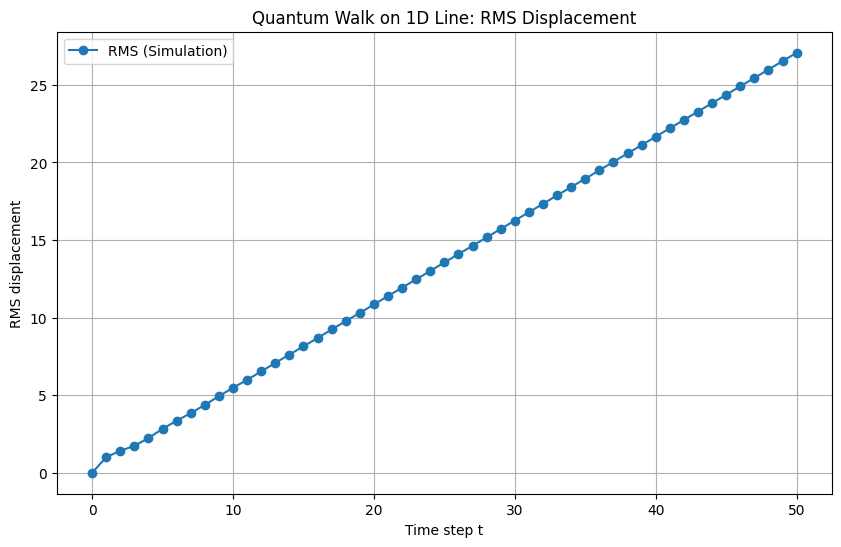

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(t_values, rms_actual, 'o-', label='RMS (Simulation)')
plt.xlabel('Time step t')
plt.ylabel('RMS displacement')
plt.title('Quantum Walk on 1D Line: RMS Displacement')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
state_50 = states[50]
positions = np.array(sorted(state_50.keys()))
probs = np.array([np.abs(state_50[x][0])**2 + np.abs(state_50[x][1])**2 for x in positions])
probs /= np.sum(probs)

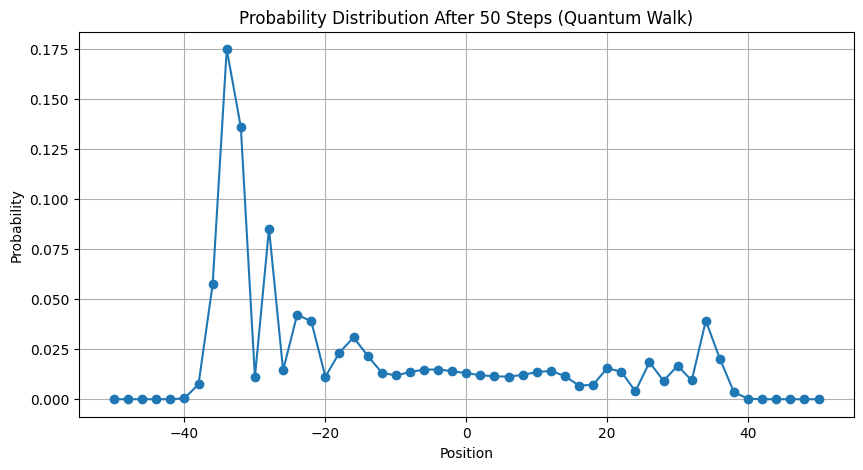

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(positions, probs, marker='o')
plt.xlabel("Position")
plt.ylabel("Probability")
plt.title("Probability Distribution After 50 Steps (Quantum Walk)")
plt.grid(True)
plt.show()

# Problem 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def build_directed_edges(graph):
    edges = []
    for u, neighs in graph.items():
        for v in neighs:
            edges.append((u, v))
    return edges

In [ ]:
def build_quantum_operators(graph):
    # Returns (U, edge_index, incoming, outgoing)
    edges = build_directed_edges(graph)
    m = len(edges)
    edge_index = {e:i for i,e in enumerate(edges)}
    incoming = {v:[] for v in graph}
    outgoing = {v:[] for v in graph}
    for i,(u,v) in enumerate(edges):
        outgoing[u].append(i)
        incoming[v].append(i)

    # Coin C (block-diagonal on outgoing edges of each vertex)
    C = np.zeros((m,m), dtype=complex)
    for v in graph:
        idxs = outgoing[v]
        d = len(idxs)
        if d == 0:
            continue
        s = np.ones((d,1))/np.sqrt(d)
        G = 2 * (s @ s.T) - np.eye(d)

        for ii, a in enumerate(idxs):
            for jj, b in enumerate(idxs):
                C[a,b] = G[ii,jj]

    # Shift S: |u->v> -> |v->u>
    S = np.zeros((m,m), dtype=complex)
    for i,(u,v) in enumerate(edges):
        j = edge_index[(v,u)]   # requires graph undirected (both arcs present)
        S[j,i] = 1.0

    U = S @ C
    return U, edge_index, incoming, outgoing

In [ ]:
def initial_state_at_vertex(start, outgoing, edge_index):
    # equal superposition over outgoing arcs from `start`
    m = sum(len(lst) for lst in outgoing.values())
    psi = np.zeros((m,), dtype=complex)
    idxs = outgoing[start]
    if len(idxs) == 0:
        raise ValueError("Start vertex has no outgoing edges")
    amp = 1/np.sqrt(len(idxs))
    for i in idxs:
        psi[i] = amp
    return psi

In [ ]:
def run_quantum_walk(graph, start, target, T):
    U, edge_index, incoming, outgoing = build_quantum_operators(graph)
    psi = initial_state_at_vertex(start, outgoing, edge_index)
    for _ in range(T):
        psi = U @ psi
    prob = sum(np.abs(psi[i])**2 for i in incoming[target])
    return prob, psi

In [ ]:
def run_classical_walk(graph, start, target, T):
    verts = list(graph.keys())
    n = len(verts)
    idx = {v:i for i,v in enumerate(verts)}
    P = np.zeros((n,n))
    for u in verts:
        i = idx[u]
        deg = len(graph[u])
        if deg == 0:
            P[i,i] = 1.0
        else:
            for v in graph[u]:
                P[i, idx[v]] = 1.0/deg
    p = np.zeros((n,))
    p[idx[start]] = 1.0
    for _ in range(T):
        p = p @ P
    return p[idx[target]], p, verts

## Cyclic Graph

In [ ]:
n=6
graph = {i: [ (i-1)%n, (i+1)%n ] for i in range(n)}
start = 0
target = 3
T = 10

In [ ]:
q_prob, psi = run_quantum_walk(graph, start, target, T)
c_prob, c_dist, verts = run_classical_walk(graph, start, target, T)

In [ ]:
print(f"Graph: {n}-cycle, start={start}, target={target}, T={T}")
print(f"Quantum (Grover coin) success probability at t after {T} steps: {q_prob:.6f}")
print(f"Classical random walk probability at t after {T} steps: {c_prob:.6f}")

Graph: 6-cycle, start=0, target=3, T=10
Quantum (Grover coin) success probability at t after 10 steps: 1.000000
Classical random walk probability at t after 10 steps: 0.000000


In [ ]:
# Quantum vertex probs
U, edge_index, incoming, outgoing = build_quantum_operators(graph)
psi = initial_state_at_vertex(start, outgoing, edge_index)
for _ in range(T):
    psi = U @ psi
q_vertex_probs = {v: sum(np.abs(psi[i])**2 for i in incoming[v]) for v in graph}

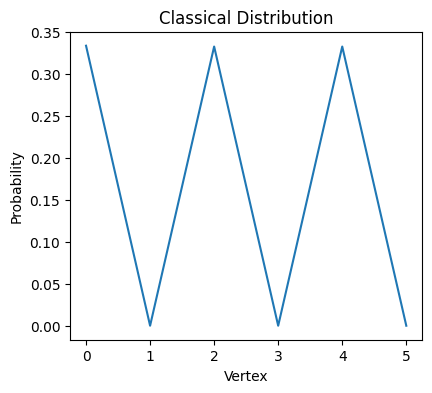

In [ ]:
plt.figure(figsize=(10,4))

# Classical distribution line plot
plt.subplot(1,2,1)
plt.plot(verts, c_dist)
plt.title("Classical Distribution")
plt.xlabel("Vertex")
plt.ylabel("Probability")
plt.show()

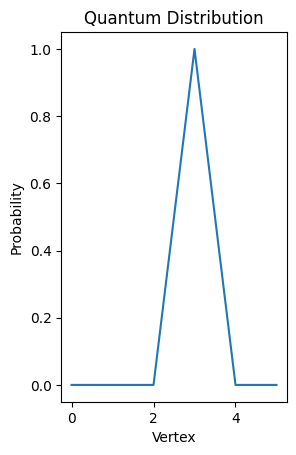

In [ ]:
x_quantum = sorted(q_vertex_probs.keys())
y_quantum = [q_vertex_probs[v] for v in x_quantum]
# Quantum distribution line plot
plt.subplot(1,2,2)
plt.plot(x_quantum, y_quantum)
plt.title("Quantum Distribution")
plt.xlabel("Vertex")
plt.ylabel("Probability")
plt.show()

## 2D Graph

In [ ]:
rows = 4
cols = 5

graph = {}

for r in range(rows):
    for c in range(cols):
        v = r * cols + c
        neighbors = []

        # up
        if r > 0:
            neighbors.append((r-1)*cols + c)
        # down
        if r < rows-1:
            neighbors.append((r+1)*cols + c)
        # left
        if c > 0:
            neighbors.append(r*cols + (c-1))
        # right
        if c < cols-1:
            neighbors.append(r*cols + (c+1))

        graph[v] = neighbors

In [ ]:
start = 0
target = 3
T = 10

In [ ]:
q_prob, psi = run_quantum_walk(graph, start, target, T)
c_prob, c_dist, verts = run_classical_walk(graph, start, target, T)

In [ ]:
print(f"Graph: {n}-cycle, start={start}, target={target}, T={T}")
print(f"Quantum (Grover coin) success probability at t after {T} steps: {q_prob:.6f}")
print(f"Classical random walk probability at t after {T} steps: {c_prob:.6f}")

Graph: 6-cycle, start=0, target=3, T=10
Quantum (Grover coin) success probability at t after 10 steps: 0.055915
Classical random walk probability at t after 10 steps: 0.000000


In [ ]:
# Quantum vertex probs
U, edge_index, incoming, outgoing = build_quantum_operators(graph)
psi = initial_state_at_vertex(start, outgoing, edge_index)
for _ in range(T):
    psi = U @ psi
q_vertex_probs = {v: sum(np.abs(psi[i])**2 for i in incoming[v]) for v in graph}

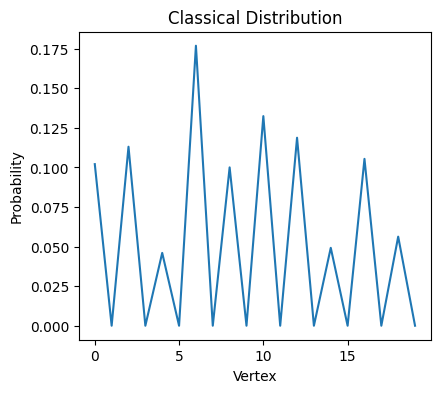

In [ ]:
plt.figure(figsize=(10,4))

# Classical distribution line plot
plt.subplot(1,2,1)
plt.plot(verts, c_dist)
plt.title("Classical Distribution")
plt.xlabel("Vertex")
plt.ylabel("Probability")
plt.show()

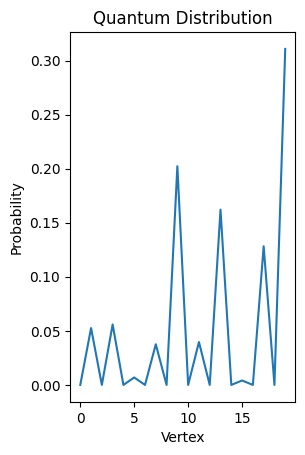

In [ ]:
x_quantum = sorted(q_vertex_probs.keys())
y_quantum = [q_vertex_probs[v] for v in x_quantum]
# Quantum distribution line plot
plt.subplot(1,2,2)
plt.plot(x_quantum, y_quantum)
plt.title("Quantum Distribution")
plt.xlabel("Vertex")
plt.ylabel("Probability")
plt.show()

## Hypercube

In [ ]:
def hypercube_graph(d):
    graph = {}
    n = 1 << d   # number of vertices = 2^d

    for v in range(n):
        neighbors = []
        for bit in range(d):
            # Flip the `bit`-th bit of v to get a neighbor
            u = v ^ (1 << bit)
            neighbors.append(u)
        graph[v] = neighbors

    return graph

In [42]:
d = 4  # dimension
graph = hypercube_graph(d)

In [43]:
start = 0
target = 3
T = 10

In [44]:
q_prob, psi = run_quantum_walk(graph, start, target, T)
c_prob, c_dist, verts = run_classical_walk(graph, start, target, T)

In [45]:
print(f"Graph: {n}-cycle, start={start}, target={target}, T={T}")
print(f"Quantum (Grover coin) success probability at t after {T} steps: {q_prob:.6f}")
print(f"Classical random walk probability at t after {T} steps: {c_prob:.6f}")

Graph: 6-cycle, start=0, target=3, T=10
Quantum (Grover coin) success probability at t after 10 steps: 0.000000
Classical random walk probability at t after 10 steps: 0.125000


In [46]:
# Quantum vertex probs
U, edge_index, incoming, outgoing = build_quantum_operators(graph)
psi = initial_state_at_vertex(start, outgoing, edge_index)
for _ in range(T):
    psi = U @ psi
q_vertex_probs = {v: sum(np.abs(psi[i])**2 for i in incoming[v]) for v in graph}

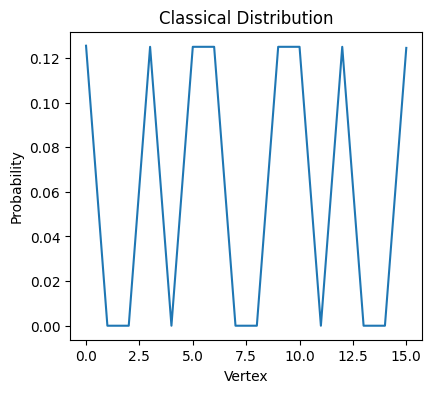

In [47]:
plt.figure(figsize=(10,4))

# Classical distribution line plot
plt.subplot(1,2,1)
plt.plot(verts, c_dist)
plt.title("Classical Distribution")
plt.xlabel("Vertex")
plt.ylabel("Probability")
plt.show()

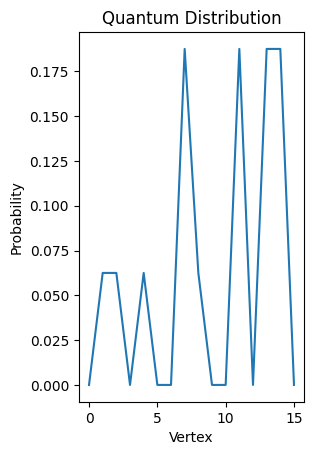

In [48]:
x_quantum = sorted(q_vertex_probs.keys())
y_quantum = [q_vertex_probs[v] for v in x_quantum]
# Quantum distribution line plot
plt.subplot(1,2,2)
plt.plot(x_quantum, y_quantum)
plt.title("Quantum Distribution")
plt.xlabel("Vertex")
plt.ylabel("Probability")
plt.show()